In [1]:
import matplotlib.pyplot as plt
def show_grayscale(rows, columns, at, pixel_array, sz):
    import scipy
    ax = plt.subplot(rows, columns, at)
    interp_array = scipy.ndimage.zoom(pixel_array.reshape(sz,sz), 4.0, order=5)
    plt.imshow(interp_array.reshape(sz*4, sz*4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        show_grayscale(2, n, i+1, original[i], sz)
        show_grayscale(2, n, i+1+n, decoded[i], sz)
    plt.show(block=True)

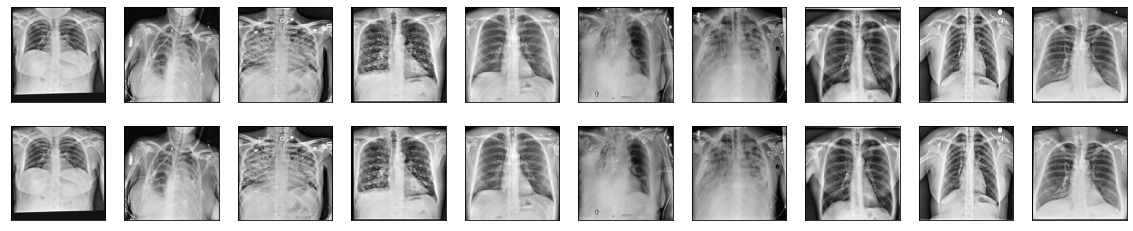

In [62]:
import glob
import imageio
import numpy as np
import cv2
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

pngs = glob.glob("e:/github/lin*/COVID*/data/train/*.png")
sz,imgs=128,[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for png in pngs[:]:
    if len(imgs) % 100 == 0:
        print('{0} of {1}'.format(len(imgs), len(pngs)), end = '\r')
    img = imageio.imread(png)
    if len(img.shape) > 2:
        # print('{0} {1} -> '.format(img.shape, img.dtype))
        img = rgb2gray(img)
        img = img_as_ubyte(img)
        # print('{0} {1}'.format(img.shape, img.dtype))
        # continue
    img = clahe.apply(img)
    img = resize(img, (sz,sz))
    width = np.max(img) - np.min(img)
    img = img - np.min(img)
    img = img/width
    img = img.reshape((sz,sz,1))
    imgs = imgs + [img]
show_original_decoded(imgs[:10], imgs[:10], sz)

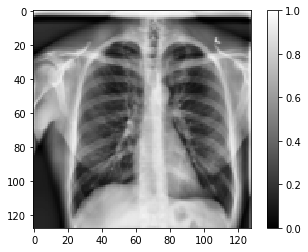

In [63]:
plt.figure()
plt.imshow(imgs[7].reshape((sz,sz)), cmap=plt.cm.gray)
plt.colorbar()
plt.grid(False)
plt.show()

In [43]:
from keras import backend as K

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [92]:
def vae_loss(z_mean, z_log_var, y_true, y_pred):
    """Compute VAE loss, using either mse or crossentropy."""
    from tensorflow.keras.losses import mse, binary_crossentropy
    img_pixels = sz * sz
    use_mse = True
    if use_mse:
        match_loss = mse(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    else:
        match_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred)) * img_pixels
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(match_loss + kl_loss)

In [93]:
def build_autoencoder(sz, optimizer):
    from keras.layers import Dense, Input, SpatialDropout2D
    from keras.layers import Conv2D, Flatten, Lambda
    from keras.layers import LocallyConnected2D, ZeroPadding2D
    from keras.layers import MaxPooling2D, UpSampling2D
    from keras.layers import Reshape, Conv2DTranspose
    from keras.layers import ActivityRegularization
    from keras.models import Model
    from keras.datasets import mnist
    from keras.losses import mse, binary_crossentropy
    from keras.utils import plot_model

    # create encoder side
    input_img = Input(shape=(sz,sz,1))
    x = Conv2D(16, (5,5), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = SpatialDropout2D(0.1)(x)
    x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)    
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    # x = MaxPooling2D((2,2), padding='same')(x)
    encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)

    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)
    print(shape)

    # generate latent vector Q(z|X)
    latent_dim = 8
    x = Flatten()(encoded_layer)
    x = Dense(latent_dim, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(4, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(16, (3,3), activation='relu', padding='same')(x)
    #x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (5,5), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, 
                        loss=lambda y_true, y_pred: vae_loss(z_mean, z_log_var, y_true, y_pred))
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder

In [94]:
autoencoder, encode_only, decode_only = build_autoencoder(sz, 'adadelta')
    # 'binary_crossentropy')
    # 'mean_squared_error')
    # vae_loss)

(None, 8, 8, 4)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 128, 128, 16) 160         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 64, 64, 32)   4640        max_pooling2d_27[0][0]           
____________________________________________________________________________

In [95]:
import numpy as np
test_count = int(len(imgs)/10)
x_test = imgs[:test_count]
x_train = imgs[test_count:]
x_train, x_test = np.array(x_train), np.array(x_test)
print(x_train.shape, x_test.shape)

(12072, 128, 128, 1) (1341, 128, 128, 1)


In [104]:
autoencoder.fit(x_train, x_train, 
                epochs=1024, batch_size=512, 
                shuffle=True, validation_data=(x_test,x_test))

Train on 12072 samples, validate on 1341 samples
Epoch 1/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 279.5046 - val_loss: 300.5190
Epoch 2/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 277.3304 - val_loss: 303.8617
Epoch 3/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 280.0411 - val_loss: 309.0879
Epoch 4/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 279.9929 - val_loss: 300.2975
Epoch 5/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 279.3842 - val_loss: 307.0905
Epoch 6/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 284.1436 - val_loss: 299.9198
Epoch 7/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 276.6947 - val_loss: 301.4656
Epoch 8/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 277.4438 - val_loss: 303.1698
Epoch 9/1024
12072/12072 [==============================] - 19s

Epoch 74/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 277.5986 - val_loss: 307.4762
Epoch 75/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 277.0489 - val_loss: 301.2224
Epoch 76/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 276.8349 - val_loss: 307.6692
Epoch 77/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 278.6811 - val_loss: 303.4193
Epoch 78/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 274.4979 - val_loss: 302.5872
Epoch 79/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 279.0169 - val_loss: 305.3483
Epoch 80/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 280.9580 - val_loss: 304.6310
Epoch 81/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 273.5029 - val_loss: 304.6462
Epoch 82/1024
12072/12072 [==============================] - 19s 2ms/step - loss: 280.0957 - val_loss: 3

ResourceExhaustedError:  OOM when allocating tensor with shape[512,32,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients_3/model_6/conv2d_transpose_24/conv2d_transpose_grad/Conv2D (defined at C:\Python36\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_1708600]

Function call stack:
keras_scratch_graph


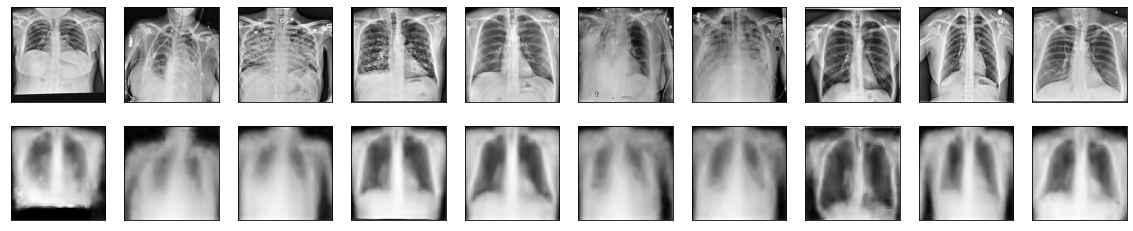

In [105]:
encode_only_imgs = encode_only.predict(x_test[:10])
if False:
    for n in range(10):
        print("shape of encoded = ", encode_only_imgs[2].shape)
        hist, bins = np.histogram(encode_only_imgs[2])
        print(hist)
        print(bins)
decoded_imgs = decode_only.predict(encode_only_imgs[2])
show_original_decoded(x_test[:10], decoded_imgs, sz)

In [100]:
import matplotlib.pyplot as plt
def g(**kwargs):
    plt.figure(2)
    latent = np.array([list(kwargs.values())])
    decoded = decode_only.predict(latent)
    plt.imshow(decoded.reshape(sz,sz))
    plt.gray()
    return kwargs['1']

In [101]:
from ipywidgets import interactive_output,Layout
import ipywidgets as widgets

In [106]:
%matplotlib inline
latent_dim = encode_only_imgs[2].shape[-1]
kwargs = {}
for k in range(latent_dim):
    kwargs[str(k)] = \
        widgets.FloatSlider(value=0,
                            min=-2.0,max=2.0,step=0.01,
                            orientation='vertical',
                            layout=Layout(padding='0%'))
w = interactive_output(g,kwargs)
display(widgets.HBox(list(kwargs.values()),layout=Layout(padding='0%')),w)

Output()